# TP2 - Filtros en Imagenes 

Librerias utilizadas a lo largo del trabajo

In [1]:
import random
import os

import cv2
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import scipy.signal as signal

Carga de imagenes y archivos relevantes al tarbajo

In [2]:
from IPython.display import clear_output
!wget https://raw.githubusercontent.com/newtonis/tps_imagenes/master/tp2/filtros/letra-a.png
!wget https://raw.githubusercontent.com/newtonis/tps_imagenes/master/tp2/filtros/black-sky.png
!wget https://raw.githubusercontent.com/newtonis/tps_imagenes/master/tp2/filtros/eight.tif
!wget https://raw.githubusercontent.com/newtonis/tps_imagenes/master/tp2/filtros/moon.png
!wget https://raw.githubusercontent.com/newtonis/tps_imagenes/master/tp2/filtros/high-boost.png
!wget https://raw.githubusercontent.com/newtonis/tps_imagenes/master/tp2/filtros/high-boost.png
!wget https://raw.githubusercontent.com/newtonis/tps_imagenes/master/tp2/filtros/zebra.png
!wget https://raw.githubusercontent.com/newtonis/tps_imagenes/master/tp2/fourier_transform/fspecial/unsharp.
!wget https://raw.githubusercontent.com/newtonis/tps_imagenes/master/tp2/filtros/tunel-good.png
!wget https://raw.githubusercontent.com/newtonis/tps_imagenes/master/tp2/filtros/lena.png
!wget https://raw.githubusercontent.com/newtonis/tps_imagenes/master/tp2/filtros/img-slicing.png
clear_output()

## Filtros pasa bajos

## Ejemplo 1

En el siguiente ejemplo veremos como aplicando a una imagen un filtro pasa bajos promediador de tamaño distinto de kernel cambia el resultado que se observa en la imagen de salida


Utilizaremos la imagen que se observa a continuación

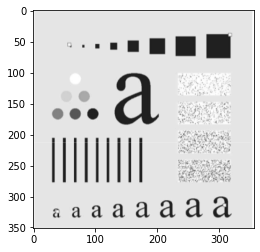

In [3]:
imagen_as = cv2.imread('letra-a.png', cv2.IMREAD_GRAYSCALE)
plt.imshow(imagen_as, cmap='gray', vmin=0, vmax=255)

Para este ejemplo realizaremos la convolución con el kernel a mano en una funcion que llamaremos `low_pass_filter()` que nos permita especificar el tamaño del kernel y el tipo de filtro aplicado, promediador o ponderado.

In [4]:
def low_pass_filter(img, dim=3, type="prom"):
    assert dim%2 != 0
    new_img = np.zeros((img.shape[0], img.shape[1]), dtype=float)
    pad = dim // 2
    def compute_mask(sub_img, x, y):
      val = 0
      if type == "prom":
        mask = np.full((dim, dim), 1)
      if type == "pond":
        mask = np.array([
                         [1, 2, 1],
                         [2, 4 ,2],
                         [1, 2, 1]
                        ])
      for i in range(dim):
        for j in range(dim):
          val += mask[i][j] * sub_img[i+x][j+y]
      return val / dim**2

    dummy_img = np.pad(img, pad, mode="edge")
    for i in range(img.shape[0]):
      for j in range(img.shape[1]):
        new_img[i][j] = compute_mask(dummy_img, i, j)
    
    return new_img


Se realizan ciertos experimentos para distintos tamaños de kernel (3, 5, 7, 9 y 15) y veremos los resultados a continuación.

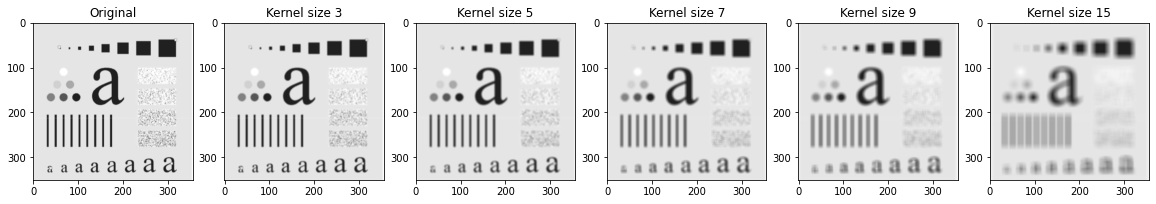

In [5]:
kernel_sizes = [3, 5, 7, 9, 15]
figure, axes = plt.subplots(ncols=6, figsize=(20, 20))
axes[0].imshow(imagen_as, cmap="gray", vmin=0, vmax=255)
axes[0].set_title("Original")
for i in range(len(kernel_sizes)):
  imagen_as_prom = low_pass_filter(imagen_as, dim=kernel_sizes[i])
  axes[i+1].imshow(imagen_as_prom, cmap="gray", vmin=0, vmax=255)
  axes[i+1].set_title(f'Kernel size {kernel_sizes[i]}')

## Ejemplo 2

Se busca en este ejemplo aplicar el filtro pasa bajos y mostrar como se pueden recuperar ciertas características o objetos de la imagen aplicando un threshold

Para eso utilizaremos la imagen observada a continuación

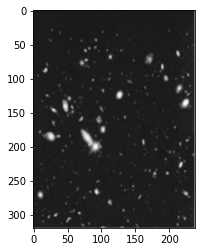

In [6]:
black_sky = cv2.imread('black-sky.png', cv2.IMREAD_GRAYSCALE)
plt.imshow(black_sky , cmap='gray', vmin=0, vmax=255)

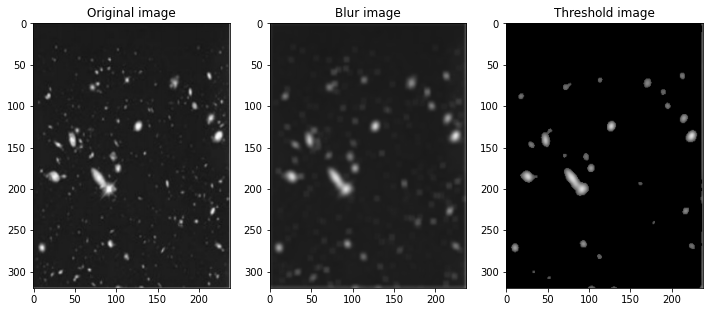

In [7]:
def apply_threshold(img, percentage):
  new_img = np.zeros((img.shape[0], img.shape[1]))
  assert 0 < percentage < 1
  for i in range(img.shape[0]):
    for j in range(img.shape[1]):
        if img[i][j] > percentage*255:
          new_img[i][j] = img[i][j]
  return new_img

figure, axes = plt.subplots(ncols=3, figsize=(12, 12))

black_sky_blur = low_pass_filter(black_sky, 7)
black_sky_blur_th = apply_threshold(black_sky_blur, 0.3)

_ = axes[0].imshow(black_sky , cmap='gray', vmin=0, vmax=255)
_ = axes[0].set_title("Original image")

_ = axes[1].imshow(black_sky_blur, cmap="gray", vmin=0, vmax=255)
_ = axes[1].set_title("Blur image")

_ = axes[2].imshow(black_sky_blur_th, cmap="gray", vmin=0, vmax=255)
_ = axes[2].set_title("Threshold image")

# Filtros no lineales


A continuación veremos la implementación de un filtro no lineal para remover ruido conocido como _salt & pepper_ presente en una imagen de unas monedas. La imagen original (sin el ruido) se puede observar abajo

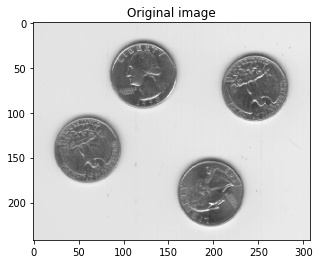

In [8]:
img = Image.open('eight.tif')
coins = np.array(img)
_ = plt.imshow(coins, cmap='gray', vmin=0, vmax=255)
_ = plt.title("Original image")

Definiremos una función que nos permita agregarle el ruido conocido como _salt and pepper_ a la imagen. También definiremos un filtro mediana con el que luego contrastaremos los resultados de aplicar este filtro a la imagen con el ruido

In [9]:
def salt_and_pepper_noise(img, prob):
    '''
    Add salt and pepper noise to image
    prob: Probability of the noise
    '''
    new_image = np.zeros(img.shape, np.uint8)
    thres = 1 - prob 
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            rdn = random.random()
            if rdn < prob:
                new_image[i][j] = 0
            elif rdn > thres:
                new_image[i][j] = 255
            else:
                new_image[i][j] = img[i][j]
    return new_image

def median_filter(img, dim=3):
    assert dim%2 != 0
    new_img = np.zeros((img.shape[0], img.shape[1]), dtype=float)
    pad = dim // 2

    def compute_mask(sub_img, x, y):
      val = 0
      mask = sub_img[x:x+dim, y:y+dim]
      mask = mask.flatten()
      mask = sorted(mask)
      while len(mask) > 1:
        if len(mask) > 1:
          mask = mask[1:]
        if len(mask) > 1:
          mask = mask[:-1]
      return mask[0]

    dummy_img = np.pad(img, pad, mode="edge")
    for i in range(img.shape[0]):
      for j in range(img.shape[1]):
        new_img[i][j] = compute_mask(dummy_img, i, j)

    return new_img

Ahora comparemos como actúa el filtro pasa bajo visto anteriormente versus el filtro no lineal mediana frente al ruido de la imagen

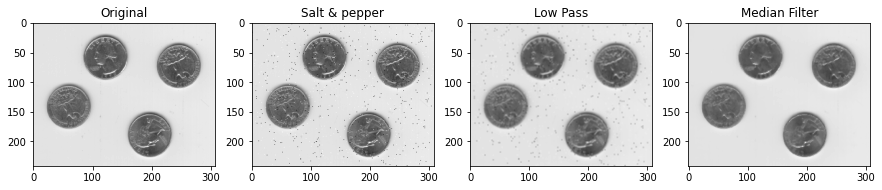

In [10]:
# coins is original image
coins_with_salt_and_pepper = salt_and_pepper_noise(coins, 0.005)
coins_sp_low_pass = low_pass_filter(coins_with_salt_and_pepper, dim=3, type="prom")
coins_sp_median = median_filter(coins_with_salt_and_pepper, 3)

images = {
          "Original": coins, 
          "Salt & pepper": coins_with_salt_and_pepper,
          "Low Pass": coins_sp_low_pass,
          "Median Filter": coins_sp_median
          }

figure, axes = plt.subplots(ncols=4, figsize=(15,15))
for i, img in enumerate(images):
  axes[i].imshow(images[img], cmap="gray", vmin=0, vmax=255)
  axes[i].set_title(f'{img}')

# Filtros pasa altos

En esta sección trabajaremos con filtros pasa altos. Comenzaremos presentando el filtro laplaciano sobre una imagen de una luna para lograr resaltar los contornos de la misma. En la celda siguiente podemos observar la imagen original

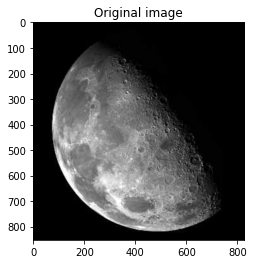

In [11]:
moon = cv2.imread('moon.png', cv2.IMREAD_GRAYSCALE)
_ = plt.imshow(moon, cmap='gray', vmin=0, vmax=255)
_ = plt.title("Original image")

## Laplace

Se define le filtro laplaciano sobre una imagen como

$$\nabla^2 (f(x, y)) = 	\frac{\partial f(x, y)}{\partial x} + \frac{\partial f(x, y)}{\partial y}$$

teniendo en cuenta esto entonces podemos escribir

$$\nabla^2 (f(x, y)) = 	[f(x-1, y-1) + f(x-1, y+1) + f(x+1, y) + f(x-1, y) + f(x, y+1) + f(x, y-1) + f(x+1, y-1) + f(x+1, y+1)] - 8f(x, y)$$

Tener en cuenta que esta definición extiende a las esquinas del kernel. Entonces el kernel queda definido como 


In [12]:
  def laplaciano_high_pass(img, dim=3):
    assert dim%2 != 0
    new_img = np.zeros((img.shape[0], img.shape[1]), dtype=float)
    pad = dim // 2
    def compute_mask(sub_img, x, y):
      val = 0
      mask = np.array([
                      [1, 1, 1],
                      [1, -8 ,1],
                      [1, 1, 1]
                      ])
      for i in range(dim):
        for j in range(dim):
          val += mask[i][j] * sub_img[i+x][j+y]
      return val

    dummy_img = np.pad(img, pad, mode="edge")
    for i in range(img.shape[0]):
      for j in range(img.shape[1]):
        new_img[i][j] = compute_mask(dummy_img, i, j)
    
    return new_img


Podemos observar los resultados de aplicar el filtro sobre la imagen a continuación. Se pueden ver que remarca las transiciones de alta frecuencia, como los bordes y los cráteres, mientras que apaga las secciones mas monotonas de la imagen.

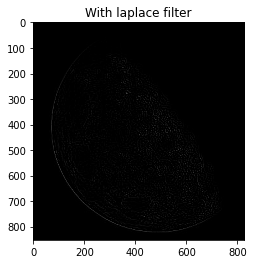

In [13]:
moon_laplaciano = laplaciano_high_pass(moon)
_ = plt.imshow(moon_laplaciano, cmap='gray', vmin=0, vmax=255)
_ = plt.title("With laplace filter")

Presentaremos un filtro capaz de aplicar el contorno de la imagen sobre la imagen original. Esto surge de aplicar a nuestra imagen de salida la trasformación

$$ g(x, y)_{out} = 	\cases{f(x,y) - \nabla^2 f(x, y) \\  f(x,y) + \nabla^2 f(x, y)} $$

donde el primer caso es para un valor negativo en el centro del kernel y el segundo caso para cuando encontramos un valor positivo.

Al realizar la resta para el caso anterior, se observa que se puede obtener la suma de lo anterior con el fondo con el siguiente kernel

In [14]:
  def laplaciano_con_fondo(img, dim=3):
    assert dim%2 != 0
    new_img = np.zeros((img.shape[0], img.shape[1]), dtype=float)
    pad = dim // 2
    def compute_mask(sub_img, x, y):
      val = 0
      mask = np.array([
                      [-1, -1, -1],
                      [-1, 9 , -1],
                      [-1, -1, -1]
                      ])
      for i in range(dim):
        for j in range(dim):
          val += mask[i][j] * sub_img[i+x][j+y]
      return val

    dummy_img = np.pad(img, pad, mode="edge")
    for i in range(img.shape[0]):
      for j in range(img.shape[1]):
        new_img[i][j] = compute_mask(dummy_img, i, j)
    
    return new_img

Si aplicamos este filtro, a diferencia con el anterior, se mantiene el fondo y sobre el se remarcan los contornos o las transiciones de alta frecuencia. Podemos ver de las 3 imagenes como la ultima parece tener una mayor nitidez.

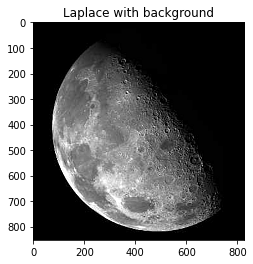

In [15]:
moon_laplaciano_con_fondo = laplaciano_con_fondo(moon)
_ = plt.imshow(moon_laplaciano_con_fondo, cmap='gray', vmin=0, vmax=255)
_ = plt.title("Laplace with background")

## High Boost

Otro filtro conocido pasa altos es el _high boost fitler_ en donde contamos con un parametro A para variar la "nitidez" o como se resaltan los detalles de la imagen. 

In [16]:
  def high_boost_filter(img, A=1, dim=3):
    assert dim%2 != 0
    new_img = np.zeros((img.shape[0], img.shape[1]), dtype=float)
    pad = dim // 2

    def compute_mask(sub_img, x, y):
      val = 0
      mask = np.array([
                      [-1, -1, -1],
                      [-1, 8 + A , -1],
                      [-1, -1, -1]
                      ])
      for i in range(dim):
        for j in range(dim):
          val += mask[i][j] * sub_img[i+x][j+y]
      return val

    dummy_img = np.pad(img, pad, mode="edge")
    for i in range(img.shape[0]):
      for j in range(img.shape[1]):
        new_img[i][j] = compute_mask(dummy_img, i, j)
    
    return new_img

Podemos observar a continuación la imagen original y el filtro aplicado para un A de 0.7 y un A de 1.7

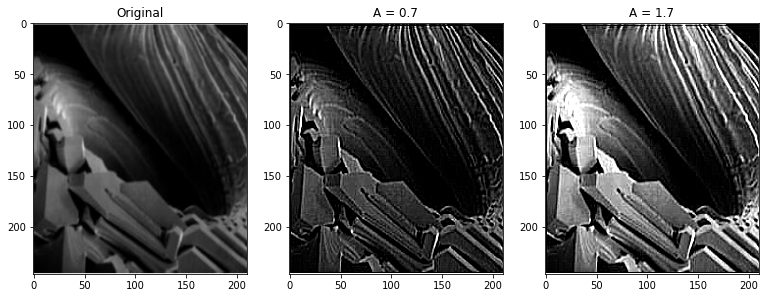

In [17]:
high_boost_example = cv2.imread('high-boost.png', cv2.IMREAD_GRAYSCALE)
high_boost_example_1_7 = high_boost_filter(high_boost_example, A=1.7)
high_boost_example_0_7 = high_boost_filter(high_boost_example, A=0.7)

images = {
          "Original": high_boost_example, 
          "A = 0.7": high_boost_example_0_7,
          "A = 1.7": high_boost_example_1_7,
          }

figure, axes = plt.subplots(ncols=3, figsize=(13, 13))
for i, img in enumerate(images):
  axes[i].imshow(images[img], cmap='gray', vmin=0, vmax=255)
  axes[i].set_title(f'{img}')


## Sobel

Otro filtro interesante en lo que son filtros pasa altos es el filtro de Sobel, basado en el cálculo del gradiente diferencial tanto en la direccion X como en la dirección Y para la detección de bordes 

Sobre una imagen de una zebra veremos el filtro en acción

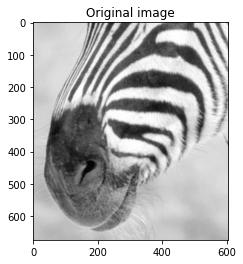

In [18]:
zebra = cv2.imread('zebra.png', cv2.IMREAD_GRAYSCALE)
_ = plt.imshow(zebra, cmap='gray', vmin=0, vmax=255)
_ = plt.title("Original image")

Definimos la función que aplicara la mascara correspondiente, seteando como default la dirección X.

In [19]:
  def sobel(img, dim=3, direction="x"):
    assert dim%2 != 0
    mask = np.array([
                    [-1, -2, -1],
                    [0, 0, 0],
                    [1, 2, 1]
                    ])
    new_img = np.zeros((img.shape[0], img.shape[1]), dtype=float)
    pad = dim // 2
    def compute_mask(sub_img, x, y):
      val = 0
      mask = np.array([
                      [-1, -2, -1],
                      [0, 0, 0],
                      [1, 2, 1]
                      ])
      if direction == "y":
        mask = mask.T
      for i in range(dim):
        for j in range(dim):
          val += mask[i][j] * sub_img[i+x][j+y]
      return val

    dummy_img = np.pad(img, pad, mode="edge")
    for i in range(img.shape[0]):
      for j in range(img.shape[1]):
        new_img[i][j] = compute_mask(dummy_img, i, j)
    
    return new_img

Podemos observar la diferencia del cálculo del gradiente X frente al gradiente Y para la imagen donde la diferencia es mas notoria en los pelos de la zebra

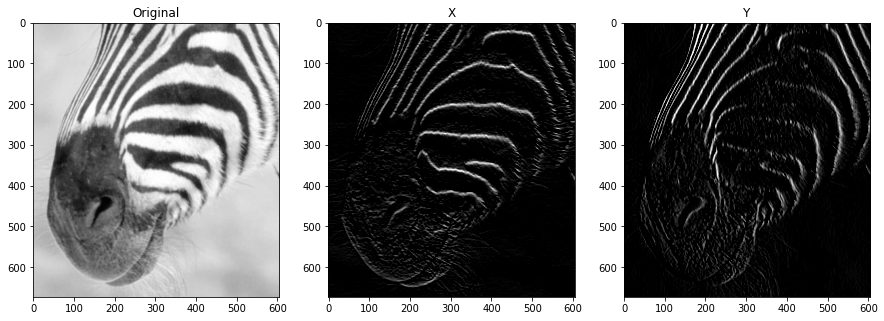

In [20]:
images = {
          "Original": zebra, 
          "X": sobel(zebra),
          "Y": sobel(zebra, direction="y"),
          }

figure, axes = plt.subplots(ncols=3, figsize=(15,15))
for i, img in enumerate(images):
  axes[i].imshow(images[img], cmap="gray", vmin=0, vmax=255)
  axes[i].set_title(f'{img}')

# Filtrado en frecuencia

## Filtro homomórfico

Dado que una imagen puede describirse en terminos de sus componentes de iluminación y de reflectancia. Dado que la transformada de fourier de estas dos componentes no es separable, es necesario realizar una transformación logaritmica para poder aplicar la transformada de fourier.

Lo que haremos será:


1.   Aplicar logaritmo sobre la imagen
2.   Realizar la transformada de fourier
3.   Realizar la multiplicación por un filtro gauseano pasa altos (aplicar el filtro en el dominio de la frecuencia)
4.   Realizar la anti transformada
5.   Aplicar exponenciación

y esto resultara en una imagen con la iluminación resaltada.


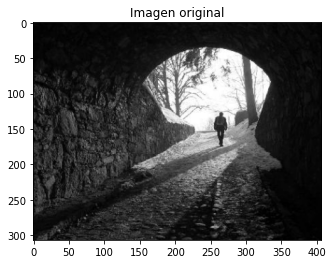

In [21]:
tunel = cv2.imread('tunel-good.png', cv2.IMREAD_GRAYSCALE)
_ = plt.imshow(tunel, cmap='gray', vmin=0, vmax=255)
_ = plt.title("Imagen original")

Como vemos, trabajaremos con una imagen de un tunel en donde la oscuridad prepondera en los costados así como en el techo.

Defeniremos la función homomorfica a aplicar

In [22]:
def homomorfic(img):
  gamma_h = 3
  gamma_l = 0.99
  img = np.array(img, dtype="float")
  x, y = np.meshgrid(np.linspace(-1, 1, img.shape[1]), np.linspace(-1, 1, img.shape[0]))
  d = np.sqrt((x * x) + (y * y))
  sigma, mu = 1, 0.0
  g = (gamma_h - gamma_l) * (1 - np.exp(-((d-mu)**2 / (sigma**2 )))) + gamma_l
  img[::] += 1 # Para evitar -inf en el logaritmo de valores en 0
  img_ln_h = np.fft.fftshift(np.fft.fft2(np.log(img)))
  for i in range(img_ln_h.shape[0]):
    for j in range(img_ln_h.shape[1]):
      img_ln_h[i][j] *= g[i][j]
  return np.exp(np.real(np.fft.ifft2(np.fft.ifftshift(img_ln_h))))

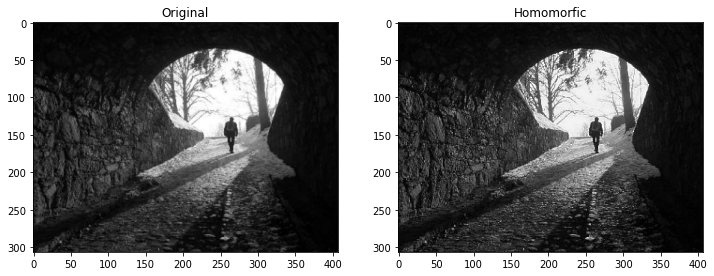

In [23]:
images = {
          "Original": tunel, 
          "Homomorfic": homomorfic(tunel),
          }

figure, axes = plt.subplots(ncols=2, figsize=(12, 12))
for i, img in enumerate(images):
  axes[i].imshow(images[img], cmap="gray", vmin=0, vmax=255)
  axes[i].set_title(f'{img}')

# Bit Slicing

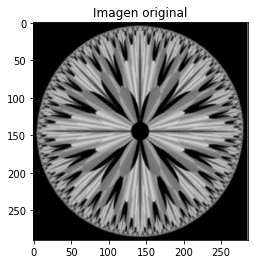

In [24]:
img_bit_slicing = cv2.imread('img-slicing.png', cv2.IMREAD_GRAYSCALE)
_ = plt.imshow(img_bit_slicing, cmap='gray', vmin=0, vmax=255)
_ = plt.title("Imagen original")

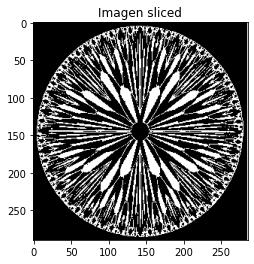

In [25]:
def slice_image(img, plane=1):
  new_bit_slicing = np.zeros_like(img)
  for i in range(img.shape[0]):
    for j in range(img.shape[1]):
      if img[i][j] & 2**plane:
        new_bit_slicing[i][j] = 255
      else:
        new_bit_slicing[i][j] = 0

  return new_bit_slicing

_ = plt.imshow(slice_image(img_bit_slicing, 6), cmap='gray', vmin=0, vmax=255)
_ = plt.title("Imagen sliced")